# Feature Selection

🎯 This exercise is a continuation of the previous one, in which you will perform ***feature selection***. 

👇 Run the cell below to load the preprocessed dataset from the *previous challenge 1 - Preprocessing Workflow*.

In [48]:
import pandas as pd

# Run this cell if you
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/02-Prepare-the-dataset/clean_dataset.csv")

data.head()


,GrLivArea,BedroomAbvGr,KitchenAbvGr,OverallCond,RoofSurface,CentralAir,SalePrice,Fin,NoGarage,RFn,Unf,sin_MoSold,cos_MoSold
0,0.380070,0.375,0.333333,0.500,0.316729,1.0,208500,0.0,0.0,1.0,0.0,0.500000,0.866025
1,-0.312090,0.375,0.333333,0.875,0.069650,1.0,181500,0.0,0.0,1.0,0.0,0.866025,-0.500000
2,0.497489,0.375,0.333333,0.500,0.228124,1.0,223500,0.0,0.0,1.0,0.0,-0.866025,-0.500000
3,0.390885,0.375,0.333333,0.500,0.442583,1.0,140000,0.0,0.0,0.0,1.0,0.500000,0.866025
4,1.134029,0.500,0.333333,0.500,0.566894,1.0,250000,0.0,0.0,1.0,0.0,-0.500000,0.866025


## (1) Correlation investigation

❓ Plot a heatmap of the ***Pearson Correlation*** between the columns of the dataset ❓

<AxesSubplot:>

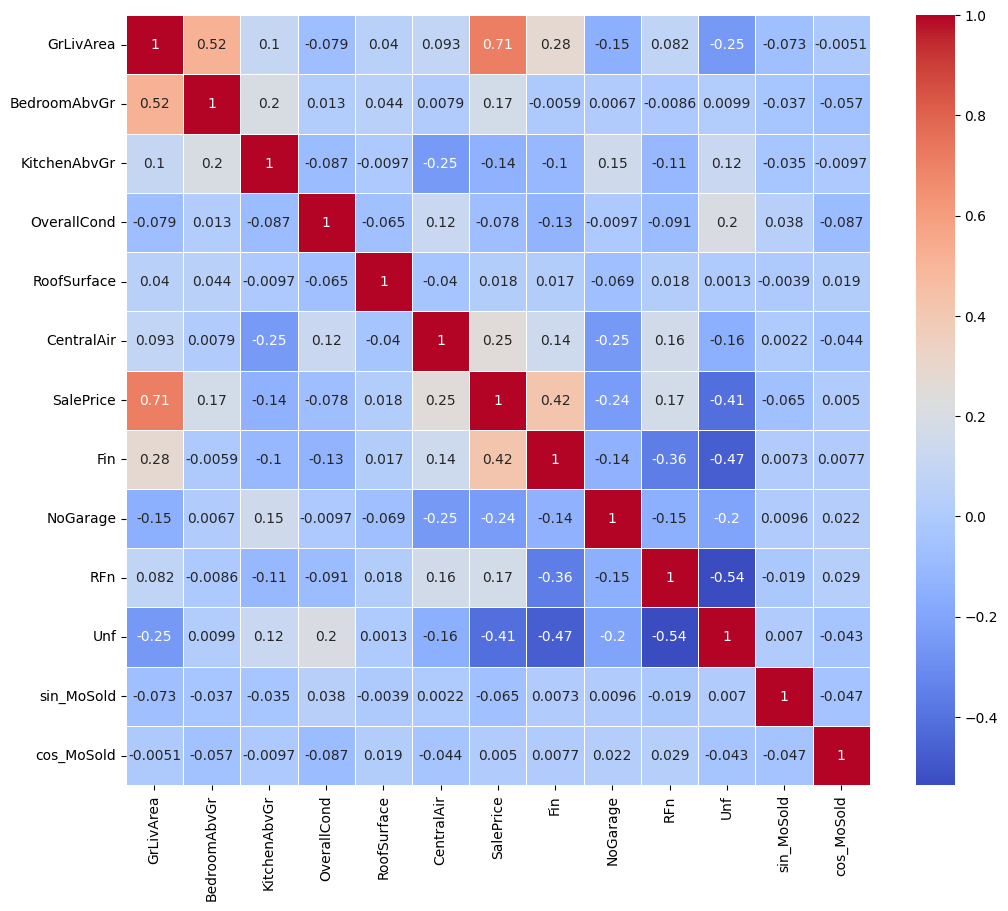

In [49]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import seaborn as sns
# Heatmap of the correlation matrix with a bigger size
plt.figure(figsize=(12, 10))

sns.heatmap(data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)


❓ Visualize the correlation between column pairs in a dataframe ❓

In [50]:
# YOUR CODE HERE
# Converting the correlation matrix into a DataFrame
import numpy as np


corr_df = data.corr().stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)


,feature_1,feature_2,correlation,absolute_correlation
6,GrLivArea,SalePrice,0.707685,0.707685
78,SalePrice,GrLivArea,0.707685,0.707685
139,Unf,RFn,-0.536355,0.536355
127,RFn,Unf,-0.536355,0.536355
1,GrLivArea,BedroomAbvGr,0.519712,0.519712
13,BedroomAbvGr,GrLivArea,0.519712,0.519712
137,Unf,Fin,-0.474129,0.474129
101,Fin,Unf,-0.474129,0.474129
97,Fin,SalePrice,0.419678,0.419678
85,SalePrice,Fin,0.419678,0.419678


❓ How many pairs of features exceed a correlation of 0.9 or -0.9 ❓

*Save your answer as an integer under variable name `correlated_features`*

In [51]:
# YOUR CODE HERE
correlated_features = 0


🧪 **Test your code**

In [52]:
from nbresult import ChallengeResult

result = ChallengeResult('correlation',
                         correlated_features = correlated_features
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/tanushrinayak/code/tanushrin/05-ML/02-Prepare-the-dataset/data-feature-selection/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_correlation.py::TestCorrelation::test_correlated_features PASSED    [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/correlation.pickle

git commit -m 'Completed correlation step'

git push origin master



## (2) Base Modelling

❓ Prepare the feature set `X` and target `y`. ❓

*Remember that we want to model the `SalePrice` with the preprocessed features.*

In [53]:
# YOUR CODE HERE
# Prepare the feature set X and target y
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']


❓ Cross validate a Linear Regression model ❓

*Save the score under variable name `base_model_score`.*

In [54]:
# YOUR CODE HERE
# Cross validate a Linear Regression model with a 5-fold cross validation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler

def cross_val_linear_reg_model(data):

    print("Shape of the dataset: ", data.shape)
    n_split = 5
    len_split = int(data.shape[0]/n_split)

    # Select only  numerical values for this example
    data_num = data.select_dtypes(exclude=['object'])

    # Shuffle the dataset rows
    data_num = data_num.sample(frac=1)

    # Initialize the 1st fold
    scores = []
    start = 0
    stop = len_split

    # Start the n-split fold CV
    for k in range(n_split): # k in [0,1,2,3,4]
        data_val = data_num.iloc[start:stop, :]
        data_train = data_num.drop(index=data_val.index)
        y_train = data_train['SalePrice']
        X_train = data_train.drop(columns=['SalePrice'])
        y_val = data_val['SalePrice']
        X_val = data_val.drop(columns=['SalePrice'])
        robust = RobustScaler()

        # Train the Robustscaler only on train set to avoid data leakage 👌
        X_train['GrLivArea'] = robust.fit_transform(X_train[['GrLivArea']])
        log =  LinearRegression()
        log.fit(X_train, y_train)

        # Apply robust scaling to val set
        X_val['GrLivArea'] = robust.transform(X_val[['GrLivArea']])
        scores.append(log.score(X_val, y_val))

        # Setup next fold
        start = stop
        stop += len_split

    # Display the mean score and the scores standard deviation
    model_score = np.array(scores).mean()
    #print(np.array(scores).std())

    return model_score

base_model_score = cross_val_linear_reg_model(data)
print("Base model_score: ", base_model_score)


Shape of the dataset:  (1460, 13)
Base model_score:  0.644586428919474


🧪 **Test your code**

In [55]:
from nbresult import ChallengeResult

result = ChallengeResult('base_model',
                         score = base_model_score
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/tanushrinayak/code/tanushrin/05-ML/02-Prepare-the-dataset/data-feature-selection/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_base_model.py::TestBase_model::test_base_model_score PASSED         [100%]

============================== 1 passed in 0.14s ===============================


💯 You can commit your code:

git add tests/base_model.pickle

git commit -m 'Completed base_model step'

git push origin master



## (3) Feature Permutation

❓ Perform a feature permutation  and rank the features by order of importance. ❓

In [56]:
# YOUR CODE HERE

from sklearn.inspection import permutation_importance

# Train the model on the whole dataset
log_model = LinearRegression().fit(X, y)

# Compute the permutation importance
permutation_score = permutation_importance(log_model, X, y, n_repeats=10,
                                           random_state=0)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature_name', 'importance_score_decrease']
importance_df.sort_values(by='importance_score_decrease', ascending=False)


,feature_name,importance_score_decrease
0,GrLivArea,1.001537
1,BedroomAbvGr,0.065028
6,Fin,0.053585
9,Unf,0.021859
2,KitchenAbvGr,0.020258
5,CentralAir,0.016155
7,NoGarage,0.011413
8,RFn,0.011371
10,sin_MoSold,0.001001
3,OverallCond,0.000193


❓ Which feature is the most important ❓

*Save your answer as a `string` under variable name `best_feature`.*

In [57]:
# YOUR CODE HERE
best_feature = "GrLivArea"


🧪 **Test your code**

In [58]:
from nbresult import ChallengeResult

result = ChallengeResult('feature_permutation',
                         feature = best_feature
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/tanushrinayak/code/tanushrin/05-ML/02-Prepare-the-dataset/data-feature-selection/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_feature_permutation.py::TestFeature_permutation::test_best_feature PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/feature_permutation.pickle

git commit -m 'Completed feature_permutation step'

git push origin master



## (4) Modelling with less complexity

❓ Drop the weak features and cross-validate a new model ❓

* You should aim at maintaining a score close to the previous one. 
* Save the score under variable name `simplified_model_score`.

<details>
    <summary>💡 Hint</summary>
    
You can try dropping features one by one starting from the ones lowest importance until your model score starts dropping significantly.
</details>

In [59]:
# YOUR CODE HERE

simplified_model_score1 = cross_val_linear_reg_model(
    data.drop(columns=['RoofSurface']))
print("Simplified model score after dropping RoofSurface: ",
      simplified_model_score1)


Shape of the dataset:  (1460, 12)
Simplified model score after dropping RoofSurface:  0.6369625435416246


In [60]:
simplified_model_score2 = cross_val_linear_reg_model(
    data.drop(columns=['RoofSurface', 'cos_MoSold']))
print("Simplified model score after dropping RoofSurface, cos_MoSold: ",
      simplified_model_score2)


Shape of the dataset:  (1460, 11)
Simplified model score after dropping RoofSurface, cos_MoSold:  0.6431433663306471


In [61]:
simplified_model_score3 = cross_val_linear_reg_model(
    data.drop(columns=["RoofSurface", "cos_MoSold", "OverallCond"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond: ",
    simplified_model_score3)


Shape of the dataset:  (1460, 10)
Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond:  0.6358829731232344


In [62]:
simplified_model_score4 = cross_val_linear_reg_model(
    data.drop(columns=["RoofSurface", "cos_MoSold", "OverallCond", "sin_MoSold"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold: ",
    simplified_model_score4)


Shape of the dataset:  (1460, 9)
Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold:  0.6219439620217274


In [63]:
simplified_model_score5 = cross_val_linear_reg_model(
    data.drop(columns=[
        "RoofSurface",
        "cos_MoSold",
        "OverallCond",
        "sin_MoSold",
        "RFn"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn: ",
    simplified_model_score5)


Shape of the dataset:  (1460, 8)


Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn:  0.6423766481834228


In [64]:
simplified_model_score6 = cross_val_linear_reg_model(
    data.drop(
        columns=[
            "RoofSurface",
            "cos_MoSold",
            "OverallCond",
            "sin_MoSold",
            "RFn",
            "NoGarage"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage: ",
    simplified_model_score6)


Shape of the dataset:  (1460, 7)


Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage:  0.6237392018622374


In [65]:
simplified_model_score7 = cross_val_linear_reg_model(
    data.drop(
        columns=[
            "RoofSurface",
            "cos_MoSold",
            "OverallCond",
            "sin_MoSold",
            "RFn",
            "NoGarage",
            "CentralAir"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage, CentralAir: ",
    simplified_model_score7)


Shape of the dataset:  (1460, 6)


Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage, CentralAir:  0.6200773871442202


In [66]:
simplified_model_score8 = cross_val_linear_reg_model(
    data.drop(
        columns=[
            "RoofSurface",
            "cos_MoSold",
            "OverallCond",
            "sin_MoSold",
            "RFn",
            "NoGarage",
            "CentralAir",
            "KitchenAbvGr"])
)
print(
    "Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage, CentralAir, KitchenAbvGr: ",
    simplified_model_score8)


Shape of the dataset:  (1460, 5)
Simplified model score after dropping RoofSurface, cos_MoSold, OverallCond, sin_MoSold, RFn, NoGarage, CentralAir, KitchenAbvGr:  0.5888044595520115


In [68]:
simplified_model_score = simplified_model_score7


🧪 **Test your code**

In [69]:
from nbresult import ChallengeResult

result = ChallengeResult('reduced_complexity_model',
                         model_score = simplified_model_score
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/tanushrinayak/code/tanushrin/05-ML/02-Prepare-the-dataset/data-feature-selection/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_reduced_complexity_model.py::TestReduced_complexity_model::test_reduced_complexity_score PASSED [100%]

============================== 1 passed in 0.11s ===============================


💯 You can commit your code:

git add tests/reduced_complexity_model.pickle

git commit -m 'Completed reduced_complexity_model step'

git push origin master



P.S. Do you remember your score before preprocessing from Challenge #1? How is it different after preprocessing?

🏁 Congratulations! Now, you know a bit more how to do ***feature selection*** !

💾 Don't forget to git add/commit/push your notebook...

🚀 ... and move on to the next challenge!